In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np

from modelname.dataset import ServiceNetworkDataset
from modelname.model import HubLocationModel

In [3]:
data = ServiceNetworkDataset()
data.nyc_neighborhoods.shape

(103,)

In [4]:
nodes = data.nyc_neighborhoods
N = np.arange(len(nodes))
distances = data.get_distances()  # from node i to node j
demands = data.get_demands()  # between node i and node j

/home/oytun/homeworks/transportation_analytics/service-network-design/modelname/dataset.py:140: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.nyc_map["center"] = self.nyc_map["geometry"].centroid


In [ ]:
model = HubLocationModel(len(nodes), 10)
model.solve(distances, demands)
solution_hubs, solution_arcs = model.get_solution()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.1 LTS")

CPU model: Intel(R) Core(TM) i5-10500H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2594821 - for non-commercial use only - registered to oy___@tum.de
Optimize a model with 10713 rows, 10712 columns and 31930 nonzeros
Model fingerprint: 0x4e6b20a4
Variable types: 0 continuous, 10712 integer (10712 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 1655.5456532
Presolve removed 7135 rows and 7120 columns
Presolve time: 0.05s
Presolved: 3578 rows, 3592 columns, 10574 nonzeros
Variable types: 0 continuous, 3592 integer (3591 binary)

Root relaxation: objective 7.479685e+04, 443 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Ob

In [12]:
print(data.nyc_neighborhoods[solution_hubs.astype(np.bool)])
print(np.all(solution_arcs == 0))
# ['Castleton Corners' 'New Brighton' 'Oakwood' 'Prospect Heights' 'Red Hook']

['East Harlem' 'Fort Greene' 'Harlem' 'Midwood' 'Tottenville'
 'Upper West Side']
False


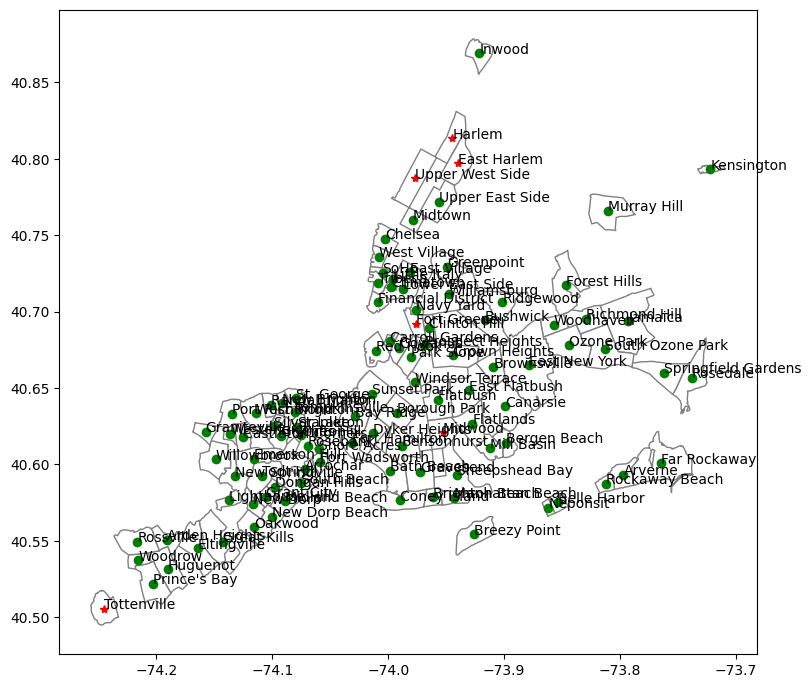

In [13]:
data.visualize(list(data.nyc_neighborhoods[solution_hubs.astype(np.bool)]))

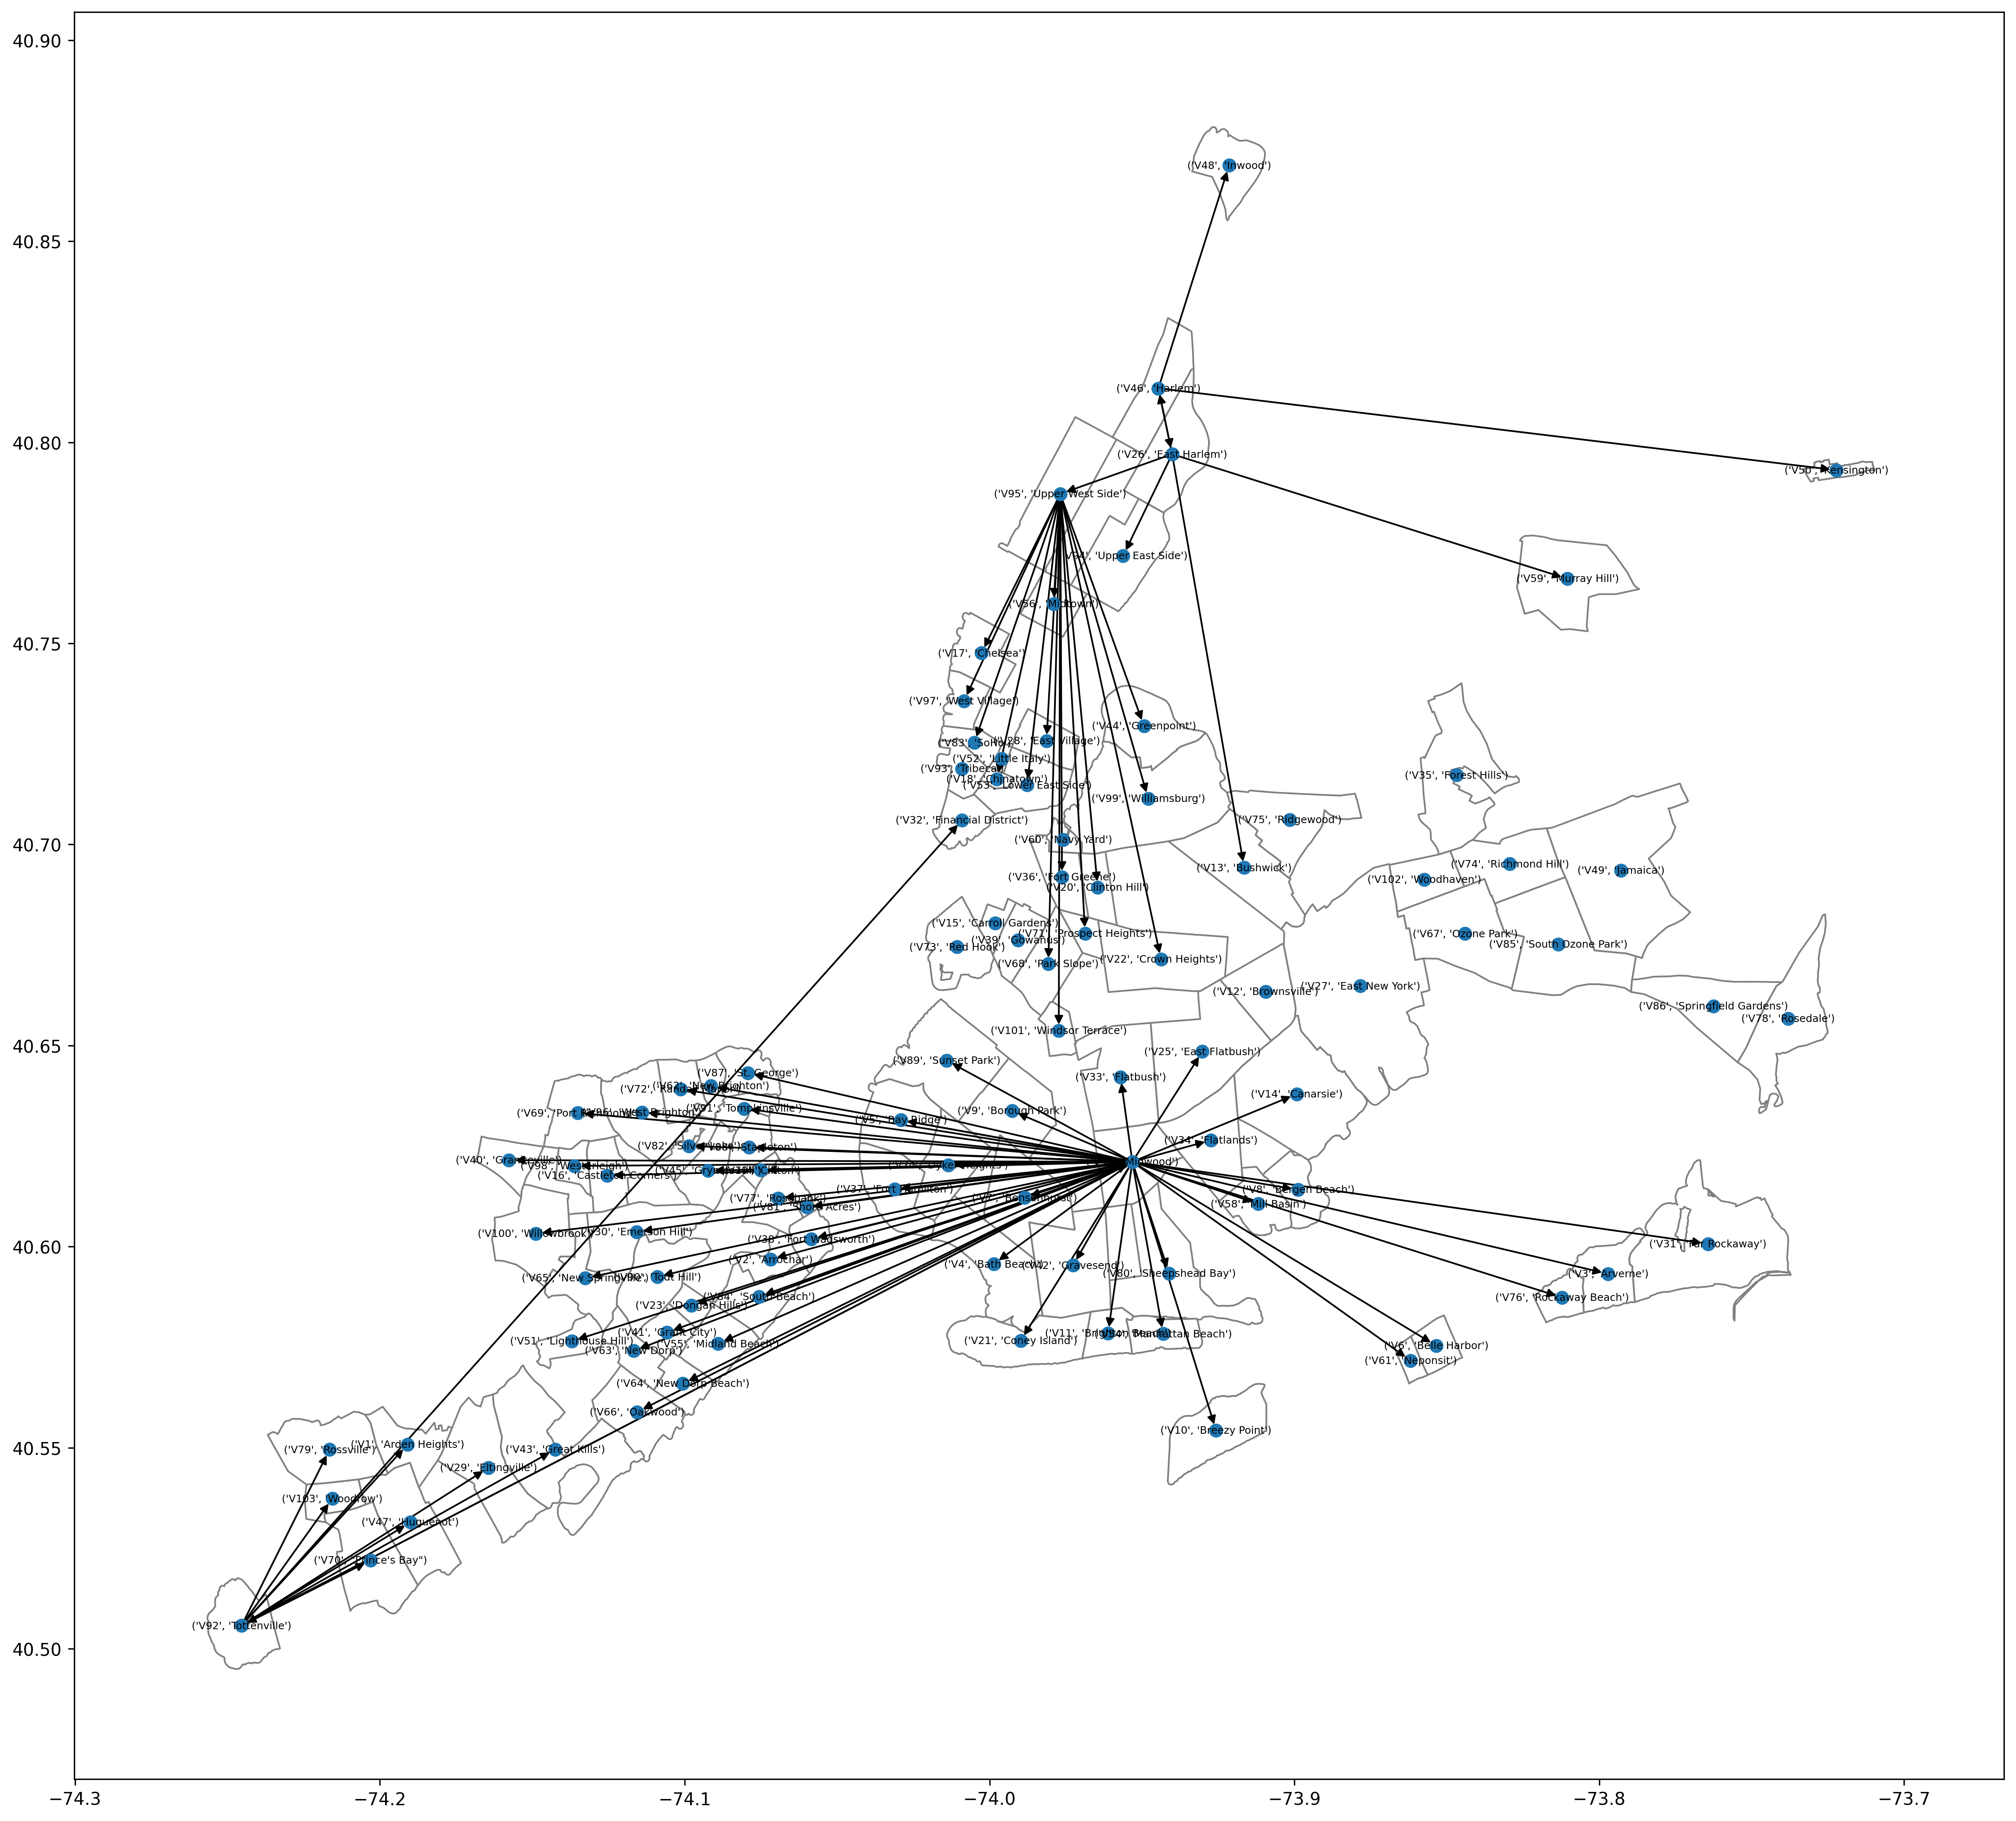

In [14]:
data.visualize_solution(solution_arcs)

In [9]:
import pandas as pd

demand = data.df.groupby(
    ["pickup_neighbourhood", "dropoff_neighbourhood"], as_index=False
)["passenger_count"].sum()
demand = pd.DataFrame(demand)

In [10]:
demand[demand["pickup_neighbourhood"] == "Brownsville"]

,pickup_neighbourhood,dropoff_neighbourhood,passenger_count
590,Brownsville,Tottenville,4
